# Chargement

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
#mdir = = mdir2 = '/home/golos/Main'
mdir = '../../..'
mdir2 = mdir+'/Programs'

In [6]:
K = Te.data2array(mdir+'/Connectomes/Jonathan/KS.npy')
dow = Te.data2array(mdir+'/Connectomes/Jonathan/downsampling.npy')
tmp = Te.data2array(mdir+'/Connectomes/Jonathan/512/centres/p06.npy')
org, cen = tmp[:,0].astype(int)-1, tmp[:,1:]

In [7]:
def detrend_svd(TC):
    N,T = TC.shape
    U, s, V = linalg.svd(TC, full_matrices=False)
    # On supprime la première composante
    U[:,0] = zeros(N)
    TC2 = U.dot(diag(s).dot(V))
    return TC2

In [8]:
def windowedFCsSym(TC, window=0.1, jump=1,  **kwa):
    ''' Returns the functionnal connectivity matrices based on a certain
    temporal window specified in percentage(<0) or number of step(>0).
    The time have to be the first dimension of TC array.
    30% faster than windowedFCs function.
    '''
    T, N = TC.shape
    ind = Tf.triSup(empty((N,N)), ind=True)
    
    if window < 1:
        lWin = int(T * window)
    else:
        lWin = window
        
    FCs = empty(((T - lWin) / jump, (N*(N-1))/2))
    for i in xrange(0, FCs.shape[0]):
        FCs[i] = Tf.fPearsonCorrelationTriangle(TC[i*jump : i*jump + lWin], ind=ind, **kwa)
        
    return FCs

In [9]:
def windowedFCsSymTukey(TC, window=0.1, jump=1,  **kwa):
    T, N = TC.shape
    ind = Tf.triSup(empty((N,N)), ind=True)
    
    if window < 1:
        lWin = int(T * window)
    else:
        lWin = window
    from scipy import signal
    TU = signal.tukey(lWin, alpha=0.5, sym=True)
        
    FCs = empty(((T - lWin) / jump, (N*(N-1))/2))
    for i in xrange(0, FCs.shape[0]):
        FCs[i] = Tf.fPearsonCorrelationTriangle( TU[:,newaxis] * TC[i*jump : i*jump + lWin], ind=ind, **kwa)
        
    return FCs

In [10]:
A512, A86 = zeros((3,21,329,512)), zeros((3,21,329,86))
for ik,k in enumerate(K):
    A512[0,ik] = Te.data2array(mdir2+'/TimeCourses/Jonathan/512/grey_matter_sansSB_sansLCR_sansGlobMean/%s.txt'%(k))[:329]
    A512[1,ik] = Te.data2array(mdir2+'/TimeCourses/Jonathan/512/grey_matter_sansSB_sansLCR_BP_filtered/%s.npy'%(k))[:329]
    A512[2,ik] = detrend_svd(A512[1,ik].T).T
    A86[0,ik] = Te.data2array(mdir2+'/TimeCourses/Jonathan/86/grey_matter_sansSB_sansLCR_sansGlobMean/%s.txt'%(k))[:329]
    A86[1,ik] = Te.data2array(mdir2+'/TimeCourses/Jonathan/86/grey_matter_sansSB_sansLCR_BP_filtered/%s.npy'%(k))[:329]
    A86[2,ik] = detrend_svd(A86[1,ik].T).T

In [62]:
# About 10 hours & 531 Go
for typ, ntyp in zip(range(3),('BRU','FIL','COM')):
    for ik,k in enumerate(K):
        for w in range(4,31):
            try: 
                tmp = Te.data2array(u'D:/Simulations/Co-Activités/%s86_w%.2i_%s.npy' %(ntyp,w,k)) 
                del tmp
            except:
                tc512 = windowedFCsSymTukey(A512[typ,ik], window=w, finite=True)
                tc86 = windowedFCsSymTukey(A86[typ,ik], window=w, finite=True)
                Te.array2data(tc512, u'D:/Simulations/Co-Activités/%s512_w%.2i_%s.npy' %(ntyp,w,k)) 
                Te.array2data(tc86, u'D:/Simulations/Co-Activités/%s86_w%.2i_%s.npy' %(ntyp,w,k)) 
                del tc512, tc86

# Visualisation

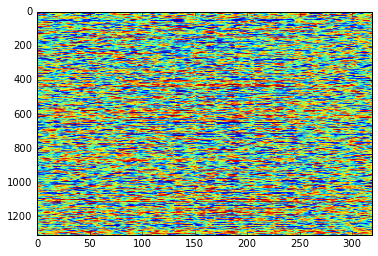

In [11]:
ntyp, w, k = 'COM', 10, 't03'
tmp = Te.data2array(u'D:/Simulations/Co-Activités/%s512_w%.2i_%s.npy' %(ntyp,w,k)) 
imshow(tmp[:,::100].T, aspect='auto');
del tmp

# Tous les noeuds

In [76]:
# Few hours
M512, M86 = zeros((2,3,21,27))
V512, V86 = zeros((2,3,21,27))
for it, ntyp in zip(range(3),('BRU','FIL','COM')):
    for ik,k in enumerate(K):
        for iw,w in enumerate(range(4,31)):
            tmp512 = Te.data2array(u'D:/Simulations/Co-Activités/%s512_w%.2i_%s.npy' %(ntyp,w,k)) 
            tmp86 = Te.data2array(u'D:/Simulations/Co-Activités/%s86_w%.2i_%s.npy' %(ntyp,w,k)) 
            M512[it,ik,iw] = mean(tmp512)
            M86[it,ik,iw] = mean(tmp86)
            V512[it,ik,iw] = var(tmp512)
            V86[it,ik,iw] = var(tmp86)
            del tmp512, tmp86

In [77]:
try:
    ps = Te.data2array(u'D:/Simulations/CA_pval.npy')
except:
    pM512, pM86, pV512, pV86 = zeros((4,3,27))
    for it, ntyp in zip(range(3),('BRU','FIL','COM')):
        for iw,w in enumerate(range(4,31)):
            pM512[it,iw] = Tf.ranksums(M512[it,:7,iw], M512[it,7:,iw])[1]
            pM86[it,iw] = Tf.ranksums(M86[it,:7,iw], M86[it,7:,iw])[1]
            pV512[it,iw] = Tf.ranksums(V512[it,:7,iw], V512[it,7:,iw])[1]
            pV86[it,iw] = Tf.ranksums(V86[it,:7,iw], V86[it,7:,iw])[1] 
    ps = array([pM512, pM86, pV512, pV86])
    Te.array2data(ps, u'D:/Simulations/CA_pval.npy')

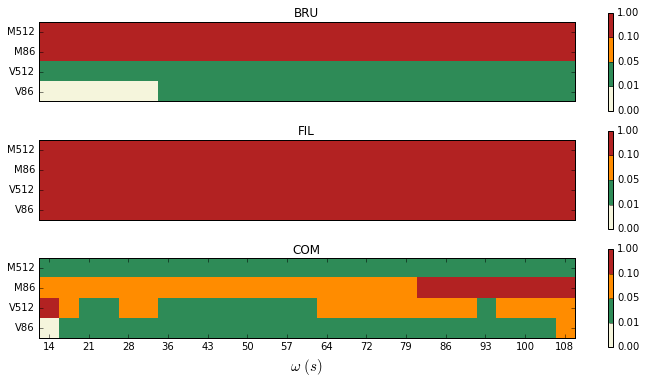

In [92]:
Td.mapMatrices(ps.swapaxes(0,1), lTitl=['BRU','FIL','COM'],
               ncl=(1,3), fs=(12,6), aspect='1', interpolation='nearest', cbar=1,
               lxy=[linspace(4*3.6, 30*3.6, 27).astype(int), ['M512','M86','V512','V86']], lxystep=[2,None], 
               labels=[r'$\omega\ (s)$', ''], fontsize=15, **Td.boundaryCmap());

# Par liens

In [113]:
# Few hours
try:
    M512, V512 = Te.data2array(u'D:/Simulations/CA_MV512.npy')
    M86, V86 = Te.data2array(u'D:/Simulations/CA_MV86.npy')
except:
    M512, V512 = zeros((2,3,27,130816,21))
    M86, V86 = zeros((2,3,27,3655,21))
    for it, ntyp in zip(range(3),('BRU','FIL','COM')):
        for ik,k in enumerate(K):
            for iw,w in enumerate(range(4,31)):
                tmp512 = Te.data2array(u'D:/Simulations/Co-Activités/%s512_w%.2i_%s.npy' %(ntyp,w,k)) 
                tmp86 = Te.data2array(u'D:/Simulations/Co-Activités/%s86_w%.2i_%s.npy' %(ntyp,w,k)) 
                M512[it,iw,:,ik] = tmp512.mean(0)
                M86[it,iw,:,ik] = tmp86.mean(0)
                V512[it,iw,:,ik] = tmp512.var(0)
                V86[it,iw,:,ik] = tmp86.var(0)
                del tmp512, tmp86
    Te.array2data(array([M512, V512]), u'D:/Simulations/CA_MV512.npy')
    Te.array2data(array([M86, V86]), u'D:/Simulations/CA_MV86.npy')

In [4]:
try:
    pM512, pV512 = Te.data2array('./vis_CoActivités_512.npy')
    pM86, pV86 = Te.data2array('./vis_CoActivités_86.npy')
except:
    pM512, pV512 = zeros((2,3,27,130816))
    pM86, pV86 = zeros((2,3,27,3655))
    for it in range(3):
        for iw in range(27):
            for il in range(130816):
                pM512[it,iw,il] = Tf.ranksums(M512[it,iw,il,:7],M512[it,iw,il,7:])[1]
                pV512[it,iw,il] = Tf.ranksums(V512[it,iw,il,:7],V512[it,iw,il,7:])[1]
            for il in range(3655):
                pM86[it,iw,il] = Tf.ranksums(M86[it,iw,il,:7],M86[it,iw,il,7:])[1]
                pV86[it,iw,il] = Tf.ranksums(V86[it,iw,il,:7],V86[it,iw,il,7:])[1]

    Te.array2data(array([pM512, pV512]), './vis_CoActivités_512.npy')
    Te.array2data(array([pM86, pV86]), './vis_CoActivités_86.npy')

In [5]:
aL5 = Tm.triToMat(512)
aL8 = Tm.triToMat(86)
c5 = Te.data2array(mdir+'/Connectomes/Jonathan/COLORS512.npy')
c8 = Te.data2array(mdir+'/Connectomes/Jonathan/COLORS.npy')
LBL5 = Te.data2array(mdir+'/Connectomes/Jonathan/LBL512_REMAKE_hemihemi.npy')
LBL8 = Te.data2array(mdir+'/Connectomes/Jonathan/LBL_REMAKE_hemihemi.npy')

In [3]:
oror5 = arange(512)
oror5[256:] = oror5[256:][::-1]
oror8 = arange(86)
oror8[43:] = oror8[43:][::-1]

In [17]:
DOW = Te.data2array(mdir+'/Connectomes/Jonathan/down_REMAKE_hemihemi.npy')
AVG = Te.data2array(mdir+'/Connectomes/Jonathan/avg_REMAKE_hemihemi.npy')

## 512 BRU
Variance all tau

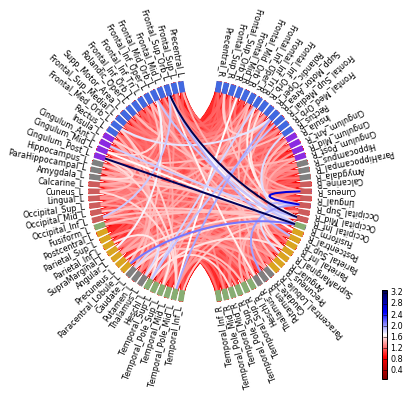

In [69]:
z = zeros((512,512))
z[aL5.tolist()] = -log(pV512[0,:].mean(0))
Td.circular(aL5, cmap='seismic_r', falpha=0.3, sym=1, con=z, down=DOW, avg=AVG, 
            node_colors=c8[oror8], node_names=LBL8[oror8], disp=False, nwidth=3, node_linewidth=.1, linewidth=2)

## 512 COM
* moyenne tout tau
* variance tau entre 36 et 60 sec (i=6 et 13)

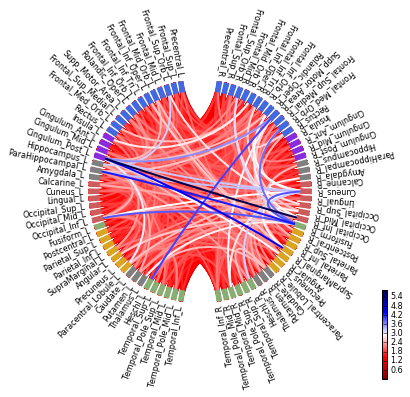

In [66]:
z = zeros((512,512))
z[aL5.tolist()] = -log(pM512[2,:].mean(0))
Td.circular(aL5, cmap='seismic_r', falpha=0.3, sym=1, con=z, down=DOW, avg=AVG, 
            node_colors=c8[oror8], node_names=LBL8[oror8], disp=False, nwidth=3, node_linewidth=.1, linewidth=2)

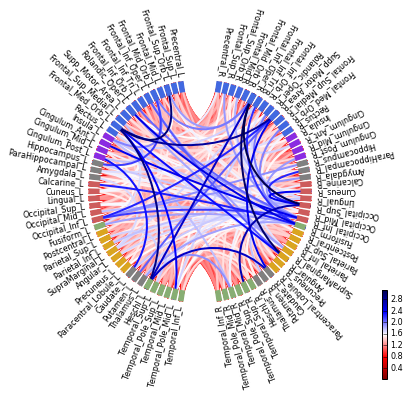

In [67]:
z = zeros((512,512))
z[aL5.tolist()] = -log(pV512[2,6:13].mean(0))
Td.circular(aL5, cmap='seismic_r', falpha=0.3, sym=1, con=z, down=DOW, avg=AVG, 
            node_colors=c8[oror8], node_names=LBL8[oror8], disp=False, nwidth=3, node_linewidth=.1, linewidth=2)

## 86 BRU
variance tau jusqu'à 30 sec (i=5)

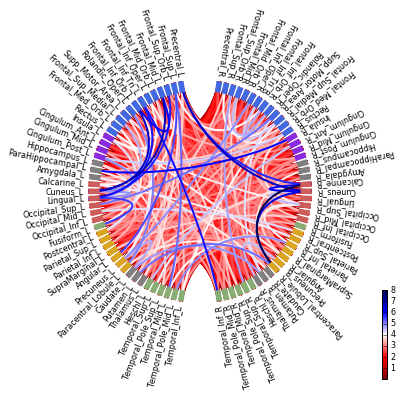

In [68]:
Td.circular(aL8, cmap='seismic_r', falpha=0.3, sym=1, con=-log(pV86[0,:6].mean(0)),
            node_colors=c8[oror8], node_names=LBL8[oror8], disp=False, nwidth=3, node_linewidth=.1, linewidth=2., )

## 86 COM
* Moyenne jusqu'à i=18
* Variance pour tout tau

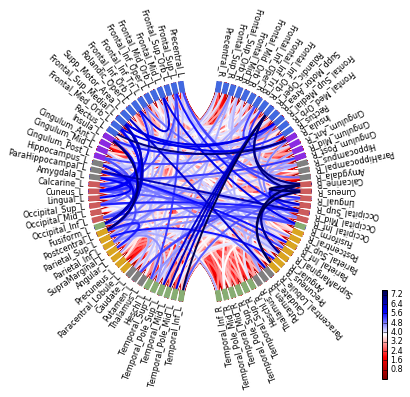

In [70]:
Td.circular(aL8, cmap='seismic_r', falpha=0.3, sym=1, con=-log(pM86[2,:19].mean(0)),
            node_colors=c8[oror8], node_names=LBL8[oror8], disp=False, nwidth=3, node_linewidth=.1, linewidth=2., )

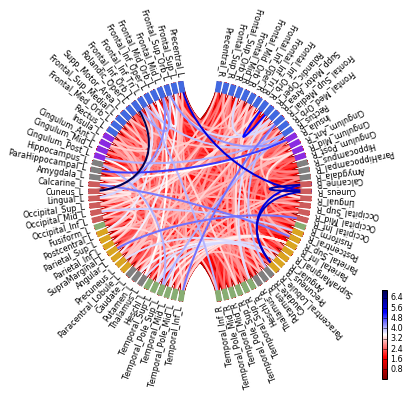

In [71]:
Td.circular(aL8, cmap='seismic_r', falpha=0.3, sym=1, con=-log(pV86[0,:].mean(0)),
            node_colors=c8[oror8], node_names=LBL8[oror8], disp=False, nwidth=3, node_linewidth=.1, linewidth=2., )

## Area importance

In [ ]:
groups = [pV512[0], pV512[1], pV512[2]]
ngroups = [u'BRU',u'FIL',u'COM']

In [ ]:
f, a = subplots(1,1, figsize=(6,4), dpi=600.)
pval = []
for g, i, t, c in zip(groups, range(3), ngroups, ['r','g','b','pink','y','aqua','k']):
    pval.append( [] )
    sortedArg = Td.sortBy(g)[0] #small to big : taking less and less small values
    for s in range(512):
        clu = sortedArg[s:]
        pval[-1].append(Tf.ranksums(var(F512[i][:7,:,clu], axis=(1,2)), var(F512[i][7:,:,clu], axis=(1,2)))[1] *512./len(clu) )
    a.semilogy(linspace(100,0,512), pval[-1], color=c, label=t)
a.set_xlabel('taille (%)')
a.set_ylabel('p-val')
a.set_xlim(100,0)
#a.set_ylim(2e-3,1)
for x in [0.1,0.05,0.01]:
    a.semilogy([100,0],[x,x], '--k')
for t, y in zip(['n.s','*','**','***'],[0.76,0.56,0.42,0.23]):
    f.text(0.91, y, t, va='center')
legend(loc=2);
pval = array(pval)

In [ ]:
groups = [-pV86[0], -pV86[1], -pV86[2]]
Is = range(3)
ngroups = [u'-BRU',u'-FIL',u'-COM']

In [ ]:
f, a = subplots(1,1, figsize=(6,4), dpi=600.)
pval = []
for g, i, t, c in zip(groups, Is, ngroups, ['r','g','b','pink','y','aqua','k']):
    pval.append( [] )
    sortedArg = Td.sortBy(g)[0] #small to big
    for s in range(86):
        clu = sortedArg[s:]
        pval[-1].append(Tf.ranksums(var(A86[i][:7,:,clu], axis=(1,2)), var(A86[i][7:,:,clu], axis=(1,2)))[1] *86./len(clu) )
    a.semilogy(linspace(100,0,86), pval[-1], color=c, label=t)
a.set_xlabel('taille (%)')
a.set_ylabel('p-val')
a.set_xlim(100,0)
#a.set_ylim(2e-3,1)
for x in [0.1,0.05,0.01]:
    a.semilogy([100,0],[x,x], '--k')
for t, y in zip(['n.s','*','**','***'],[0.76,0.56,0.42,0.23]):
    f.text(0.91, y, t, va='center')
legend(loc=2);
pval = array(pval)